In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

from biological_fuzzy_logic_networks.DREAM_analysis.utils import data_to_nodes_mapping, inhibitor_mapping
from scipy.stats import anderson_ksamp, false_discovery_control

/dccstor/ipc1/.conda/envs/biofuzznet2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
markers = ['b.CATENIN',
       'cleavedCas', 'CyclinB', 'GAPDH', 'IdU', 'Ki.67', 'p.4EBP1',
       'p.Akt.Ser473.', 'p.AKT.Thr308.', 'p.AMPK', 'p.BTK', 'p.CREB', 'p.ERK',
       'p.FAK', 'p.GSK3b', 'p.H3', 'p.HER2', 'p.JNK', 'p.MAP2K3', 'p.MAPKAPK2',
       'p.MEK', 'p.MKK3.MKK6', 'p.MKK4', 'p.NFkB', 'p.p38', 'p.p53',
       'p.p90RSK', 'p.PDPK1', 'p.PLCg2', 'p.RB', 'p.S6', 'p.S6K', 'p.SMAD23',
       'p.SRC', 'p.STAT1', 'p.STAT3', 'p.STAT5']

In [3]:
data_path = "/dccstor/ipc1/CAR/DREAM/DREAMdata/Time_aligned_per_cell_line/CL_incl_test/"
no_perturb = "BT20_EGF_time9.csv"
perturb = "BT20_iMEK_time9.csv"

In [4]:
np_data = pd.read_csv(data_path+no_perturb, index_col=0)
p_data = pd.read_csv(data_path+perturb, index_col=0)

In [5]:
data = pd.concat([np_data, p_data], axis=0)

long_data = data.melt(id_vars = [c for c in data.columns if not c in markers], 
          value_vars=markers, value_name="expression", var_name="marker")

long_data =long_data[["treatment", "marker", "expression"]]
mapping=data_to_nodes_mapping()
long_data["node_name"] = [mapping[m] if m in mapping.keys() else m for m in long_data["marker"]]
long_data

,treatment,marker,expression,node_name
0,EGF,b.CATENIN,1.224304,b-catenin
1,EGF,b.CATENIN,1.570814,b-catenin
2,EGF,b.CATENIN,1.659957,b-catenin
3,EGF,b.CATENIN,1.592938,b-catenin
4,EGF,b.CATENIN,0.993266,b-catenin
...,...,...,...,...
1250669,iMEK,p.STAT5,3.210049,STAT5
1250670,iMEK,p.STAT5,2.997203,STAT5
1250671,iMEK,p.STAT5,2.669110,STAT5
1250672,iMEK,p.STAT5,3.395471,STAT5


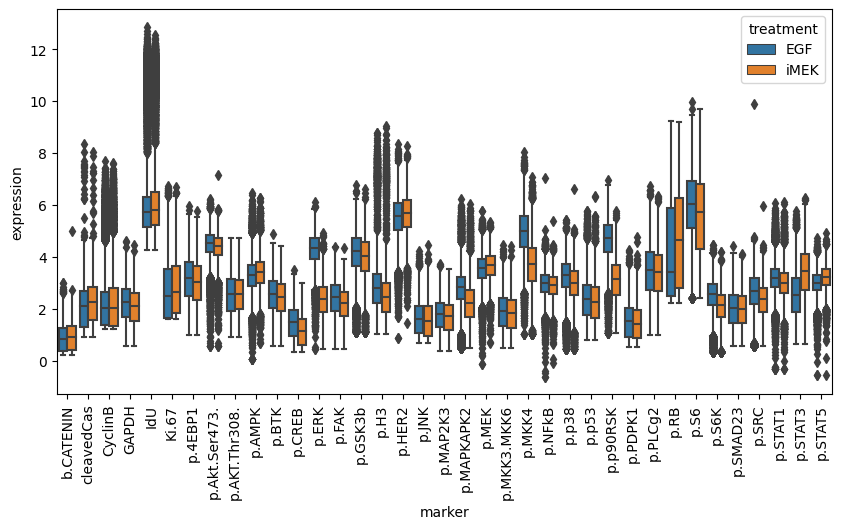

In [6]:
f = plt.figure(figsize=(10,5))
sns.boxplot(data=long_data, x="marker", hue="treatment", y="expression")
t = plt.xticks(rotation=90)

In [7]:
pkn = nx.read_gexf("/dccstor/ipc1/CAR/DREAM/DREAMdata/PKN_Alice_without_logic.gexf")

In [8]:
pkn.nodes

NodeView(('SERUM', 'SMAD23', 'AMPK', 'NFkB', 'PLCg2', 'FAK', 'PI3K', 'EGFR', 'PAK', 'PKC', 'ERK12', 'MAP3Ks', 'PIP3', 'BTK', 'SRC', 'STAT5', 'PDPK1', 'AKT_S473', 'AKT', 'p53', 'RB', 'cleavedCas', 'GSK3B', 'b-catenin', 'PTEN', 'mTOR', '4EBP1', 'MKK36', 'ERKdm2', 'p90RSK', 'MSK12', 'MAPKAPK2', 'H3', 'p38', 'S6', 'CREB', 'S6K', 'p70S6K', 'MARCKS', 'STAT1', 'AKT_T308', 'MEK12_S221', 'RAS', 'RAF', 'JNK', 'STAT3', 'EGFRFB', 'MEK12', 'MKK4', 'EGF'))

In [9]:
downstream = [n for n in nx.traversal.bfs_tree(pkn, "MEK12_S221", depth_limit=4)]
downstream = [n for n in downstream if not( n.startswith("or") | n.startswith("not") | ("and" in n))]
downstream

['MEK12_S221',
 'MEK12',
 'ERK12',
 'MKK36',
 'ERKdm2',
 'p90RSK',
 'MSK12',
 'MAPKAPK2',
 '4EBP1',
 'p38',
 'RAS',
 'H3',
 'S6',
 'CREB',
 'NFkB']

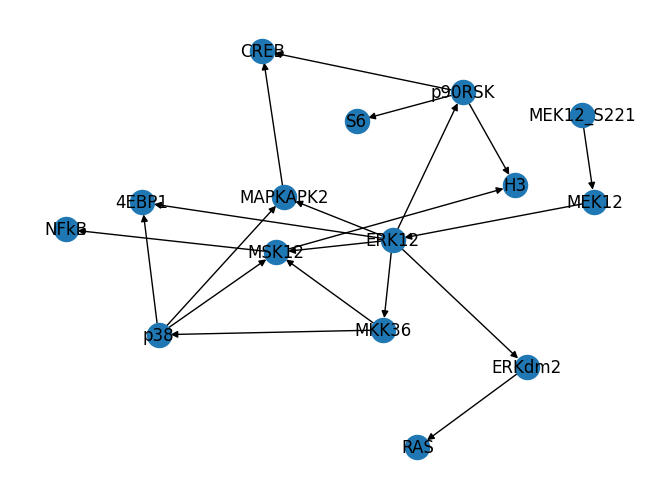

In [10]:
nx.draw(pkn.subgraph(downstream+["MEK12_S221"]), with_labels=True, pos=graphviz_layout(pkn))

In [11]:
distances = []
for n in downstream:
    distance =  len(nx.shortest_path(pkn, source='MEK12_S221', target=n))
    distances.append(distance)
dist_from_root = pd.DataFrame({"node_name": downstream, "dist": distances})
dist_from_root = dist_from_root.sort_values("dist", ascending=True)
dist_from_root = dist_from_root.merge(long_data[["node_name", "marker"]].drop_duplicates(), how="left", on="node_name")
dist_from_root = dist_from_root.dropna()
dist_from_root

,node_name,dist,marker
1,MEK12,2,p.MEK
2,ERK12,3,p.ERK
3,MKK36,4,p.MKK3.MKK6
5,p90RSK,4,p.p90RSK
7,MAPKAPK2,4,p.MAPKAPK2
8,4EBP1,4,p.4EBP1
9,p38,5,p.p38
11,H3,5,p.H3
12,S6,5,p.S6
13,CREB,5,p.CREB


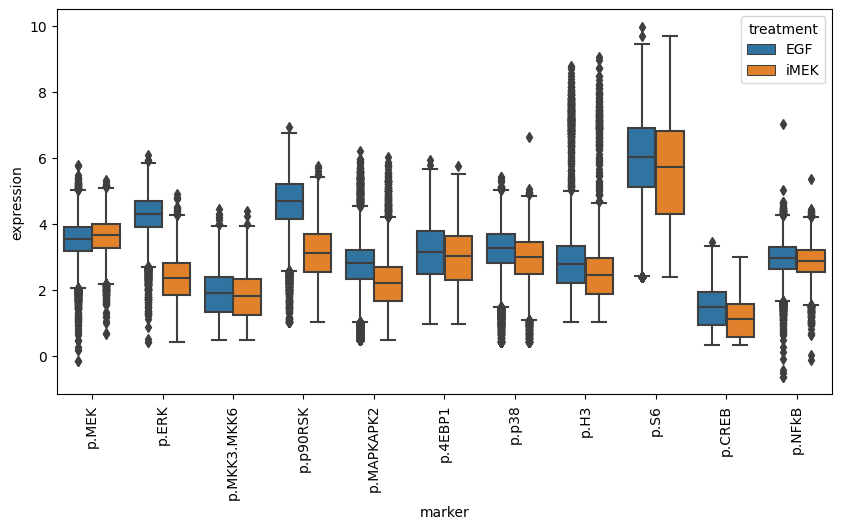

In [12]:
f = plt.figure(figsize=(10,5))
sns.boxplot(data=long_data[long_data['node_name'].isin(downstream)], x="marker", hue="treatment", y="expression",
           order=dist_from_root["marker"])
t = plt.xticks(rotation=90)

# Treatment level differences

In [13]:
res = anderson_ksamp([np_data["p.MEK"], p_data["p.MEK"]])
res


/tmp/ipykernel_727188/675754793.py:1: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  res = anderson_ksamp([np_data["p.MEK"], p_data["p.MEK"]])


Anderson_ksampResult(statistic=134.98762592882218, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)

In [14]:
p_vals = []
for m in markers:
    res = anderson_ksamp([np_data[m], p_data[m]])

    print(m, res.pvalue)
    p_vals.append(res.pvalue)

/tmp/ipykernel_727188/3499814.py:3: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  res = anderson_ksamp([np_data[m], p_data[m]])


b.CATENIN 0.001
cleavedCas 0.001
CyclinB 0.001
GAPDH 0.001
IdU 0.001
Ki.67 0.001
p.4EBP1 0.001
p.Akt.Ser473. 0.001
p.AKT.Thr308. 0.001
p.AMPK 0.001
p.BTK 0.001
p.CREB 0.001
p.ERK 0.001
p.FAK 0.001
p.GSK3b 0.001
p.H3 0.001
p.HER2 0.001
p.JNK 0.001
p.MAP2K3 0.001
p.MAPKAPK2 0.001
p.MEK 0.001
p.MKK3.MKK6 0.001
p.MKK4 0.001
p.NFkB 0.001
p.p38 0.001
p.p53 0.001
p.p90RSK 0.001
p.PDPK1 0.001
p.PLCg2 0.001
p.RB 0.001
p.S6 0.001
p.S6K 0.001
p.SMAD23 0.002318037999000299
p.SRC 0.001
p.STAT1 0.001
p.STAT3 0.001
p.STAT5 0.001


In [15]:
false_discovery_control(p_vals, method="bh")

array([0.00102778, 0.00102778, 0.00102778, 0.00102778, 0.00102778,
       0.00102778, 0.00102778, 0.00102778, 0.00102778, 0.00102778,
       0.00102778, 0.00102778, 0.00102778, 0.00102778, 0.00102778,
       0.00102778, 0.00102778, 0.00102778, 0.00102778, 0.00102778,
       0.00102778, 0.00102778, 0.00102778, 0.00102778, 0.00102778,
       0.00102778, 0.00102778, 0.00102778, 0.00102778, 0.00102778,
       0.00102778, 0.00102778, 0.00231804, 0.00102778, 0.00102778,
       0.00102778, 0.00102778])

So since the function only returns as lowest possible value 0.001, I guess most markers would be significant before correction (in this case). But it's very unlikely that we can differentiate a lot between different markers based on this and it will probably depend on the level of correction. I think the cell-level selection is much more promissing. 

# Cell level investigation

In the individual cell-level control, we checked the effectiveness of each perturbation by contrasting
the expression level of the perturbed gene (X) post-perturbation against its baseline level. We
established a threshold for expression level at the 10th percentile of gene X in the unperturbed control
distribution. We excluded any cell where gene X was perturbed but its expression exceeded this
threshold. However, if a perturbed gene’s expression was not measured in the dataset, we did not
perform this filtering.

From: arXiv:2210.17283v2 [cs.LG] 3 Jul 2023; https://arxiv.org/pdf/2210.17283.pdf

# Approach select cells that for direct neighbors of the inhibition (if measured) have values lower than the 10th percentile

In [16]:
np.percentile(np_data["p.ERK"], q=10)

3.5284750000000003

In [17]:
min(np_data["p.ERK"])

0.442259

In [20]:
sel_markers = ["p.ERK", "p.p90RSK", "p.MAPKAPK2"]
for m in sel_markers:
    q = np.percentile(np_data[m], q=10)
    above = p_data.loc[p_data[m]>q,:]
    below = p_data.loc[p_data[m]<=q,:]
    
    print(len(p_data), len(above)+len(below))
    print("Frac above: ", len(above)/(len(above)+len(below)))
    print("Frac below: ", len(below)/(len(above)+len(below)))


8360 8360
Frac above:  0.0354066985645933
Frac below:  0.9645933014354067
8360 8360
Frac above:  0.28301435406698566
Frac below:  0.7169856459330144
8360 8360
Frac above:  0.6720095693779904
Frac below:  0.32799043062200955


In [21]:
node_to_data_mapping = {v: k for k, v in mapping.items()}
node_to_data_mapping

{'EGF': 'EGF',
 'SERUM': 'SERUM',
 'b-catenin': 'b.CATENIN',
 'cleavedCas': 'cleavedCas',
 '4EBP1': 'p.4EBP1',
 'AKT_S473': 'p.Akt.Ser473.',
 'AKT_T308': 'p.AKT.Thr308.',
 'AMPK': 'p.AMPK',
 'BTK': 'p.BTK',
 'CREB': 'p.CREB',
 'ERK12': 'p.ERK',
 'FAK': 'p.FAK',
 'GSK3B': 'p.GSK3b',
 'H3': 'p.H3',
 'JNK': 'p.JNK',
 'MAP3Ks': 'p.MAP2K3',
 'MAPKAPK2': 'p.MAPKAPK2',
 'MEK12': 'p.MEK',
 'MKK36': 'p.MKK3.MKK6',
 'MKK4': 'p.MKK4',
 'NFkB': 'p.NFkB',
 'p38': 'p.p38',
 'p53': 'p.p53',
 'p90RSK': 'p.p90RSK',
 'PDPK1': 'p.PDPK1',
 'PLCg2': 'p.PLCg2',
 'RB': 'p.RB',
 'S6': 'p.S6',
 'p70S6K': 'p.S6K',
 'SMAD23': 'p.SMAD23',
 'SRC': 'p.SRC',
 'STAT1': 'p.STAT1',
 'STAT3': 'p.STAT3',
 'STAT5': 'p.STAT5'}

In [22]:
len(node_to_data_mapping.keys()) == len(mapping.keys())

True

In [23]:
treatments = ['iMEK', "iPKC", "imTOR", "iEGFR", "iPI3K", "full", "EGF"]
inhibitor_map = inhibitor_mapping()
inhibitor_map

{'EGF': 'None',
 'full': 'None',
 'iEGFR': 'EGFR',
 'iMEK': 'MEK12',
 'iPI3K': 'PI3K',
 'iPKC': 'PKC',
 'imTOR': 'mTOR'}

In [24]:
inhibited_nodes = [inhibitor_map[t] for t in treatments]
direct_neighbors = [[n for n in pkn.neighbors(inhibited_node)] if inhibited_node !="None" else [] for inhibited_node in inhibited_nodes]
direct_neighbors

[['ERK12'],
 ['MARCKS', 'NFkB', 'GSK3B'],
 ['AKT_S473', 'S6K', '4EBP1', 'p70S6K'],
 ['EGFRFB', 'RAS', 'PLCg2', 'PI3K', 'SRC', 'STAT5', 'STAT1', 'STAT3'],
 ['MAP3Ks', 'PIP3', 'BTK', 'SRC', 'PAK'],
 [],
 []]

In [25]:
[n for n in pkn.neighbors("MEK12")]

['ERK12']

In [26]:
inhibited_nodes

['MEK12', 'PKC', 'mTOR', 'EGFR', 'PI3K', 'None', 'None']

In [27]:
def get_inclusion_stats(data, selected_data):

    # Calculate some statistics about how many cells and what percentage are includes/excluded

    ### Treatment
    tr_ncells_included = pd.DataFrame(selected_data.groupby("treatment").size(), columns=["n_cells"])
    tr_ncells_excluded = pd.DataFrame(data.groupby("treatment").size(), columns=["n_cells"]) - tr_ncells_included
    tr_perc_included = (tr_ncells_included/pd.DataFrame(data.groupby("treatment").size(), columns=["n_cells"])*100).rename(columns={"n_cells": "percentage"})
    tr_perc_excluded = 100-tr_perc_included

    tr_ncells_included["in/excl"] = "in"
    tr_ncells_excluded["in/excl"] = "ex"
    tr_perc_included["in/excl"] = "in"
    tr_perc_excluded["in/excl"] = "ex"

    tr_ncells_included["n_cells/perc"] = "n_cells"
    tr_ncells_excluded["n_cells/perc"] = "n_cells"
    tr_perc_included["n_cells/perc"] = "perc"
    tr_perc_excluded["n_cells/perc"] = "perc"

    tr_ncells_included = tr_ncells_included.reset_index(drop=False)
    tr_ncells_excluded = tr_ncells_excluded.reset_index(drop=False)
    tr_perc_included   = tr_perc_included.reset_index(drop=False)
    tr_perc_excluded   = tr_perc_excluded.reset_index(drop=False)

    ### Time 
    time_ncells_included = pd.DataFrame(selected_data.groupby("time").size(), columns=["n_cells"])
    time_ncells_excluded = pd.DataFrame(data.groupby("time").size(), columns=["n_cells"]) - time_ncells_included
    time_perc_included = (time_ncells_included/pd.DataFrame(data.groupby("time").size(), columns=["n_cells"])*100).rename(columns={"n_cells": "percentage"})
    time_perc_excluded = 100-time_perc_included

    time_ncells_included["in/excl"] = "in"
    time_ncells_excluded["in/excl"] = "ex"
    time_perc_included["in/excl"] = "in"
    time_perc_excluded["in/excl"] = "ex"

    time_ncells_included["n_cells/perc"] = "n_cells"
    time_ncells_excluded["n_cells/perc"] = "n_cells"
    time_perc_included["n_cells/perc"] = "perc"
    time_perc_excluded["n_cells/perc"] = "perc"

    time_ncells_included = time_ncells_included.reset_index(drop=False)
    time_ncells_excluded = time_ncells_excluded.reset_index(drop=False)
    time_perc_included   = time_perc_included.reset_index(drop=False)
    time_perc_excluded   = time_perc_excluded.reset_index(drop=False)



    ### Treatment and Time 
    tr_time_ncells_included = pd.DataFrame(selected_data.groupby(["treatment", "time"]).size(), columns=["n_cells"])
    tr_time_ncells_excluded = pd.DataFrame(data.groupby(["treatment", "time"]).size(), columns=["n_cells"]) - tr_time_ncells_included
    tr_time_perc_included = (tr_time_ncells_included/pd.DataFrame(data.groupby(["treatment", "time"]).size(), columns=["n_cells"])*100).rename(columns={"n_cells": "percentage"})
    tr_time_perc_excluded = 100-tr_time_perc_included

    tr_time_ncells_included["in/excl"] = "in"
    tr_time_ncells_excluded["in/excl"] = "ex"
    tr_time_perc_included["in/excl"] = "in"
    tr_time_perc_excluded["in/excl"] = "ex"

    tr_time_ncells_included["n_cells/perc"] = "n_cells"
    tr_time_ncells_excluded["n_cells/perc"] = "n_cells"
    tr_time_perc_included["n_cells/perc"] = "perc"
    tr_time_perc_excluded["n_cells/perc"] = "perc"

    tr_time_ncells_included = tr_time_ncells_included.reset_index(drop=False)
    tr_time_ncells_excluded = tr_time_ncells_excluded.reset_index(drop=False)
    tr_time_perc_included   = tr_time_perc_included.reset_index(drop=False)
    tr_time_perc_excluded   = tr_time_perc_excluded.reset_index(drop=False)

    res = pd.concat([tr_ncells_excluded, tr_ncells_included, tr_perc_included, tr_perc_excluded, 
               time_ncells_excluded, time_ncells_included, time_perc_included, time_perc_excluded, 
               tr_time_ncells_excluded, tr_time_ncells_included, tr_time_perc_included, tr_time_perc_excluded ])
    return res

In [28]:
inhibitor_map = inhibitor_mapping()

mapping = data_to_nodes_mapping()
node_to_data_mapping = {v: k for k, v in mapping.items()}
node_to_data_mapping

{'EGF': 'EGF',
 'SERUM': 'SERUM',
 'b-catenin': 'b.CATENIN',
 'cleavedCas': 'cleavedCas',
 '4EBP1': 'p.4EBP1',
 'AKT_S473': 'p.Akt.Ser473.',
 'AKT_T308': 'p.AKT.Thr308.',
 'AMPK': 'p.AMPK',
 'BTK': 'p.BTK',
 'CREB': 'p.CREB',
 'ERK12': 'p.ERK',
 'FAK': 'p.FAK',
 'GSK3B': 'p.GSK3b',
 'H3': 'p.H3',
 'JNK': 'p.JNK',
 'MAP3Ks': 'p.MAP2K3',
 'MAPKAPK2': 'p.MAPKAPK2',
 'MEK12': 'p.MEK',
 'MKK36': 'p.MKK3.MKK6',
 'MKK4': 'p.MKK4',
 'NFkB': 'p.NFkB',
 'p38': 'p.p38',
 'p53': 'p.p53',
 'p90RSK': 'p.p90RSK',
 'PDPK1': 'p.PDPK1',
 'PLCg2': 'p.PLCg2',
 'RB': 'p.RB',
 'S6': 'p.S6',
 'p70S6K': 'p.S6K',
 'SMAD23': 'p.SMAD23',
 'SRC': 'p.SRC',
 'STAT1': 'p.STAT1',
 'STAT3': 'p.STAT3',
 'STAT5': 'p.STAT5'}

In [29]:
cell_lines = ["BT20", 
              "BT474", 
              "CAL148", 
              "CAL51", 
              "CAL851", 
              "DU4475", 
              "EFM192A", 
              "EVSAT", 
              "HBL100", 
              "HCC1599", 
              "HCC2185", 
              "HCC3153", 
              "HDQP1", 
              "JIMT1", 
              "MCF7", 
              "MDAMB157", 
              "MDAMB175VII", 
              "MDAMB415", 
              "MFM223", 
              "MPE600", 
              "MX1", 
              "OCUBM", 
              "UACC812", 
              "ZR7530"]

In [62]:
# Get CL data with more treatments in it
all_stats = []
for CL in cell_lines:
    print(CL)
    data = pd.read_csv(f"/dccstor/ipc1/CAR/DREAM/DREAMdata/Time_aligned_per_cell_line/CL_incl_test/{CL}.csv")

    selected_data = []
    for tr in data["treatment"].unique():
        if tr in ["EGF", "full"]:
            continue
        for time in data["time"].unique():
            sel_data = data[(data["treatment"]==tr) & (data["time"]==time)]
            inhibited_node = inhibitor_map[tr]
            direct_neighbors = [n for n in pkn.neighbors(inhibited_node) if not n in ["PLCg2", "HER2"]]
            measured_neighbors = [node_to_data_mapping[n] for n in direct_neighbors if n in node_to_data_mapping.keys()]

            for m in measured_neighbors:
                q = np.percentile(data.loc[(data["treatment"]=="EGF")&(data["time"]==time), m], q=10)
                sel_data = sel_data.loc[sel_data[m]<q]
            selected_data.append(sel_data)
        selected_data.append(data[data["treatment"]=="EGF"])
    selected_data = pd.concat(selected_data)
    
    stats = get_inclusion_stats(data, selected_data)
    stats["cell_line"] = CL
    all_stats.append(stats)
    
    selected_data.to_csv(f"/dccstor/ipc1/CAR/DREAM/DREAMdata/Time_aligned_per_cell_line/CL_incl_test/tenth_perctile/{CL}.csv",
                        index=False)

BT20
BT474
CAL148
CAL51
CAL851
DU4475
EFM192A
EVSAT
HBL100
HCC1599
HCC2185
HCC3153
HDQP1
JIMT1
MCF7
MDAMB157
MDAMB175VII
MDAMB415
MFM223
MPE600
MX1
OCUBM
UACC812
ZR7530


In [34]:
res = pd.concat(all_stats)
res

,treatment,n_cells,in/excl,n_cells/perc,percentage,time,cell_line
0,EGF,0.0,ex,n_cells,NaN,NaN,BT20
1,full,NaN,ex,n_cells,NaN,NaN,BT20
2,iEGFR,71834.0,ex,n_cells,NaN,NaN,BT20
3,iMEK,5310.0,ex,n_cells,NaN,NaN,BT20
4,iPI3K,70588.0,ex,n_cells,NaN,NaN,BT20
...,...,...,...,...,...,...,...
41,imTOR,NaN,ex,perc,97.832040,9.0,ZR7530
42,imTOR,NaN,ex,perc,99.209949,13.0,ZR7530
43,imTOR,NaN,ex,perc,98.730449,17.0,ZR7530
44,imTOR,NaN,ex,perc,98.955423,40.0,ZR7530


Some treatments or timepoints have 0 or very few selected cells, for example when one of the direct neighbours has a high 10th quantile is excludes a lot of cells. 

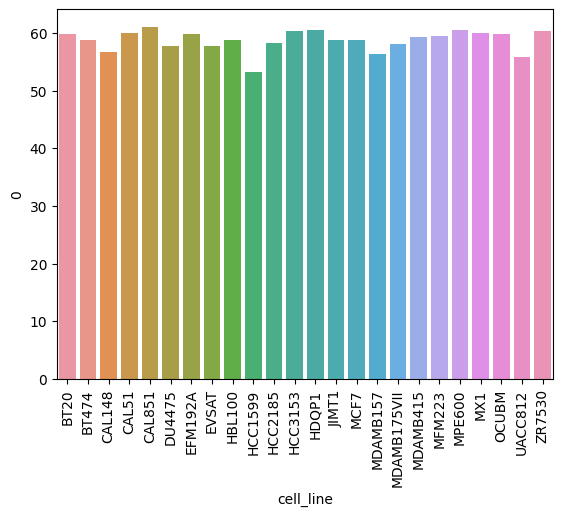

In [44]:
sns.barplot(data = pd.DataFrame(res[["cell_line", "treatment", "time"]].groupby("cell_line").size()/4).reset_index(),
           x="cell_line", y=0)
t = plt.xticks(rotation=90)

/dccstor/ipc1/.conda/envs/biofuzznet2/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/dccstor/ipc1/.conda/envs/biofuzznet2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/dccstor/ipc1/.conda/envs/biofuzznet2/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/dccstor/ipc1/.conda/envs/biofuzznet2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/dccstor/ipc1/.conda/envs/biofuzznet2/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/dccstor/ipc1/.conda/envs/biofuzznet2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice 

/dccstor/ipc1/.conda/envs/biofuzznet2/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/dccstor/ipc1/.conda/envs/biofuzznet2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/dccstor/ipc1/.conda/envs/biofuzznet2/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/dccstor/ipc1/.conda/envs/biofuzznet2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/dccstor/ipc1/.conda/envs/biofuzznet2/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/dccstor/ipc1/.conda/envs/biofuzznet2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice 

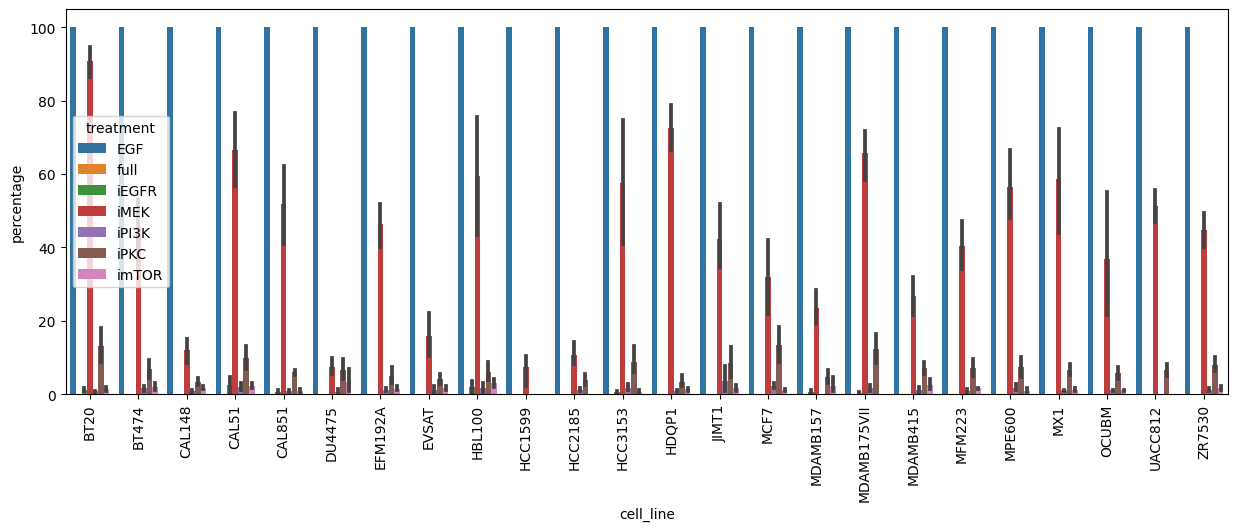

In [49]:
plt.figure(figsize=(15,5))
sns.barplot(data = res[(res["in/excl"]=="in")&(res["n_cells/perc"]=="perc")],
           x="cell_line", y="percentage", hue="treatment")
t = plt.xticks(rotation=90)

# Error bars are over different timepoints

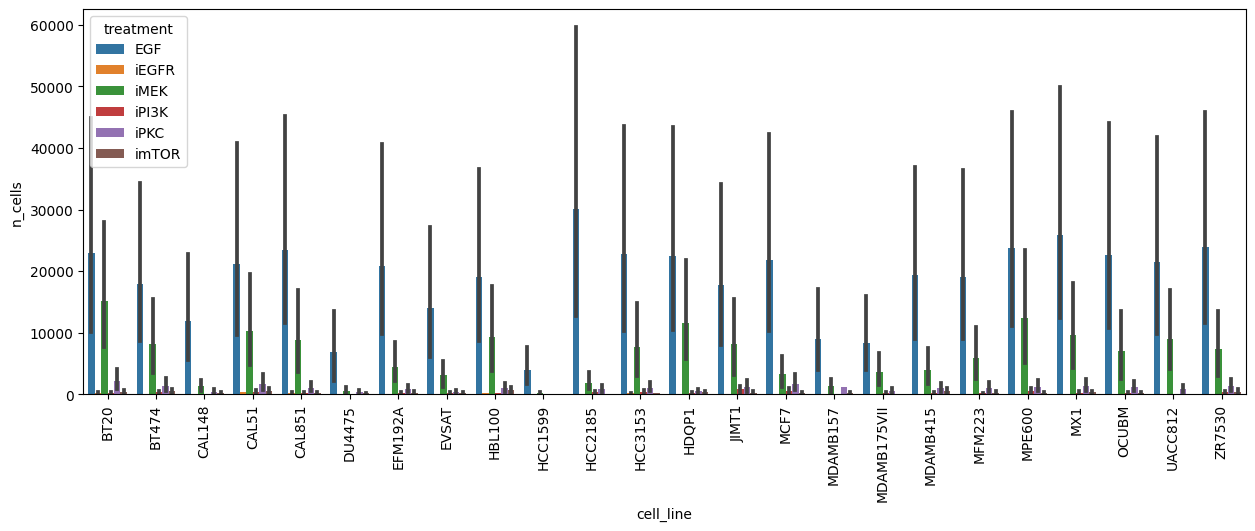

In [50]:
plt.figure(figsize=(15,5))
sns.barplot(data = res[(res["in/excl"]=="in")&(res["n_cells/perc"]=="n_cells")],
           x="cell_line", y="n_cells", hue="treatment")
t = plt.xticks(rotation=90)

# Errorbar are over different timepoint

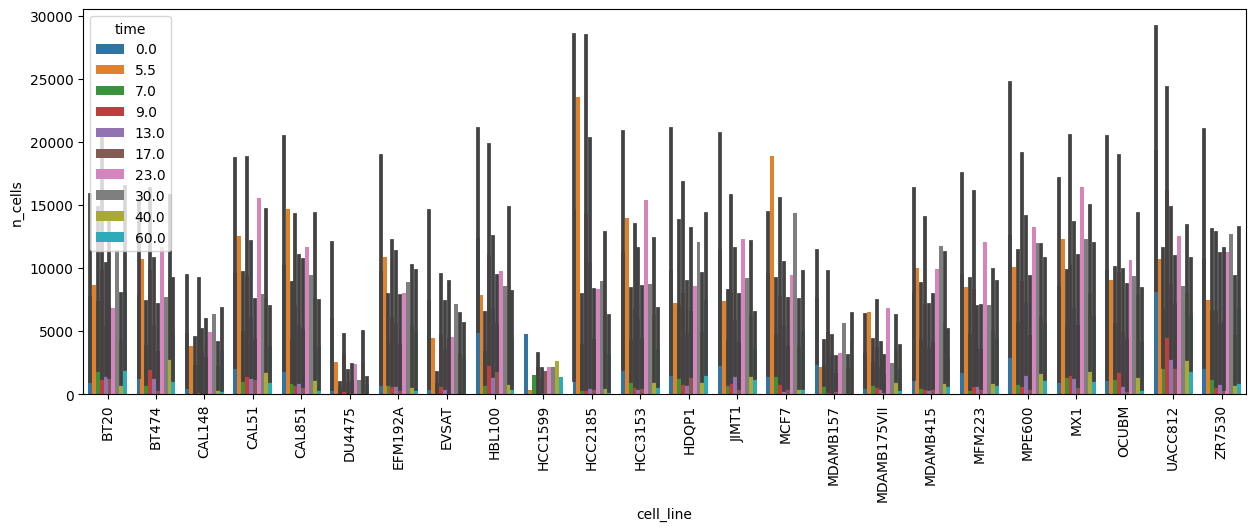

In [52]:
plt.figure(figsize=(15,5))
sns.barplot(data = res[(res["in/excl"]=="in")&(res["n_cells/perc"]=="n_cells")],
           x="cell_line", y="n_cells", hue="time")
t = plt.xticks(rotation=90)

# Errorbar are over different timepoint

(0.0, 12.0)

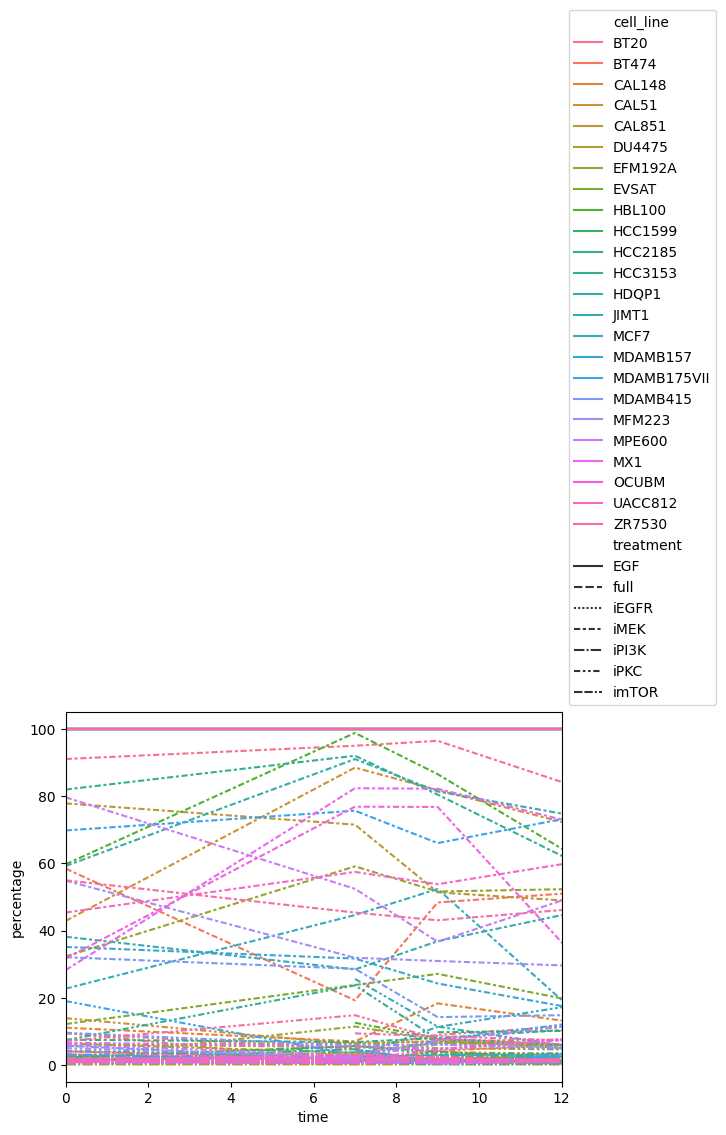

In [63]:
sns.lineplot(data = res[(res["in/excl"]=="in")&(res["n_cells/perc"]=="perc")].reset_index(),
           x="time", y="percentage", hue="cell_line", style="treatment")
plt.legend(bbox_to_anchor=(1,1))
plt.xlim((0,12))